In [2]:
import pandas as pd
import numpy as np

df_unknowns = pd.read_csv('unknown.csv')

# Get numerical values
unknowns = df_unknowns.iloc[:, 4:].get_values()

### Distribution of unknown columns


Plot the distributions of unknown columns (BSC, GSC, LDS):

BSC_1 to BSC_101


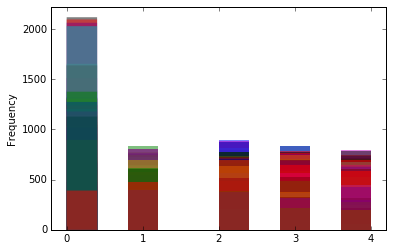

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

print '\nPlot the distributions of unknown columns (BSC, GSC, LDS):'
print '\nBSC_1 to BSC_101'

bsc = ['BSC_' + str(i) for i in xrange(1, 102)]
plot = df_unknowns[bsc].plot(kind='hist', alpha=0.5, legend=None)


Plot several random BSC samples:


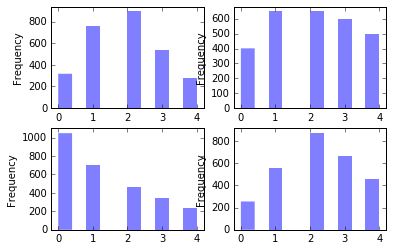

In [4]:
print '\nPlot several random BSC samples:'

fig, axes = plt.subplots(nrows=2, ncols=2)
df_unknowns['BSC_1'].plot(ax=axes[0,0], kind='hist', alpha=0.5)
df_unknowns['BSC_10'].plot(ax=axes[0,1], kind='hist', alpha=0.5)
df_unknowns['BSC_20'].plot(ax=axes[1,0], kind='hist', alpha=0.5)
df_unknowns['BSC_30'].plot(ax=axes[1,1], kind='hist', alpha=0.5)


GSC_1 to GSC_119


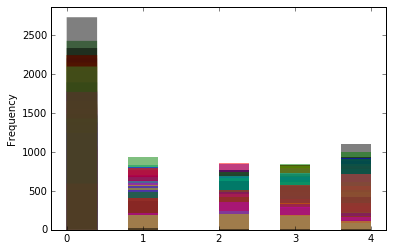

In [33]:
print '\nGSC_1 to GSC_119'

gsc = ['GSC_' + str(i) for i in xrange(1, 120)]
plot = df_unknowns[gsc].plot(kind='hist', alpha=0.5, legend=None)


LDS_1 to LDS_79


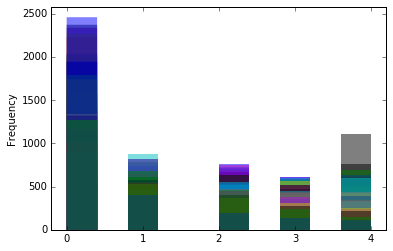

In [36]:
print '\nLDS_1 to LDS_79'

lds = ['LDS_' + str(i) for i in xrange(1, 80)]
plot = df_unknowns[lds].plot(kind='hist', alpha=0.5, legend=None)

In [3]:
def row_summary(df):
    # Extract column headers
    featNames = list(df.columns.get_values()) 
    # Get row summary (whether number of NaNs in each row)
    row_summary = df.isnull().sum(axis=1)
    # Get incomplete row indices 
    nan_row_inds = list() # incomplete row indices
    for i, x in enumerate(row_summary):
        if x > 0: nan_row_inds.append(i)
    return nan_row_inds

def clean_records(df):
    nan_row_inds = row_summary(df)
    clean_df = df.drop(df.index[nan_row_inds], inplace=False)    
    # Double check for NaNs 
    print 'Is there any NaNs in the clean records?', clean_df.isnull().values.any()
    return clean_df

df = pd.DataFrame.from_csv('Data_Adults_1.csv')
clean_df = clean_records(df)

Is there any NaNs in the clean records? False


In [6]:
# Keep only numerical values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = clean_df.select_dtypes(include=numerics)

cols2drop = ['Patient_ID', 'GROUP_ID', 'doa', 'Baseline_header_id', 'Concentration_header_id', \
              'Baseline_Reading_id', 'Concentration_Reading_id']
    
# Drop certain columns 
X = X.drop(cols2drop, axis=1, inplace=False)

print 'm =', X.shape[1]

m = 736


### K-Means Clustering

In [15]:
from sklearn.cluster import KMeans

k = 4
data = X.get_values().T
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [16]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

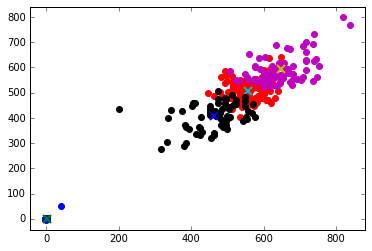

In [17]:
for i in range(k):
    # Extract observations within each cluster
    ds = data[np.where(labels==i)]
    # Plot the observations with symbol o
    plt.plot(ds[:,0], ds[:,1], 'o')
    # Plot the centroids with simbol x
    lines = plt.plot(centroids[i,0], centroids[i,1], 'x')
    plt.setp(lines, ms=8.0)
    plt.setp(lines, mew=2.0)

### Inferential Question:
- Should we divide the features into groups and analyze their distributions separately? More specifically, can we cluster the features?

Based on the plotted figure above, clustering all the features is not a good idea at this point, since there seem to be no clear cluster boundaries. However, we are able to identify the existence of outliers using this method (clustering).

### Principal Component Analysis

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
pca.fit(X.get_values())

PCA(copy=True, n_components=15, whiten=False)


Explained Variance Ratios:
[ 0.63891694  0.0892175   0.08381227  0.02315049  0.01735853  0.01439833
  0.01042989  0.00951193  0.00717123  0.00652803  0.00539808  0.00520158
  0.00443164  0.00394098  0.00330307]


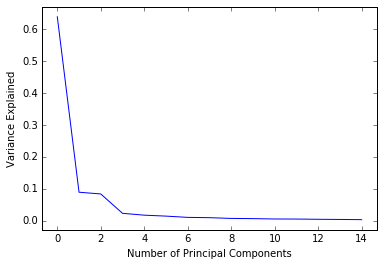

In [28]:
print '\nExplained Variance Ratios:'
print pca.explained_variance_ratio_

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Variance Explained')
plt.xlabel('Number of Principal Components')

- Can we find k most important features to construct our training data, where k is significantly smaller than m?

Given the explained variance ratios printed and plotted above, if we can settle for capturing 90% of variance, then we can find a k such that k = 10 << m = 736.

In [29]:
# Looking at what columns are favored by the first two principal dimensions 
print '\nColumns favored by the first principal component:'
pc = pd.DataFrame(pca.components_, columns=X.iloc[:, :].columns).T
pc.sort_values(0, ascending=False)[:6]


Columns favored by the first principal component:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Baseline_Vermis_9,0.094380,0.033614,-0.083460,0.138607,-0.057032,-0.052472,0.041185,0.026639,-0.041684,-0.054157,-0.091318,0.032815,0.088523,0.098256,0.112633
Baseline_Pallidum_R,0.093015,0.101915,-0.068602,0.046092,0.006636,0.016819,-0.038290,0.041850,0.056017,-0.004603,0.077882,-0.023244,0.015743,-0.072071,0.135445
Concentration_Vermis_9,0.091933,0.003287,0.085602,0.146032,-0.064774,-0.060172,0.040250,0.027106,-0.034455,-0.050062,-0.101807,0.034831,0.096725,0.070654,0.052451
Baseline_Putamen_L,0.091270,0.074613,-0.070461,0.028729,0.012304,0.025879,-0.044538,0.006870,0.033406,-0.022882,0.080905,0.009723,0.040000,-0.037924,0.078674
Baseline_Putamen_R,0.090789,0.068889,-0.072930,0.019189,0.022099,0.032056,-0.051313,-0.005592,0.021084,-0.024017,0.069760,0.020282,0.048993,-0.027178,0.085504
Baseline_Vermis_10,0.090773,0.118392,-0.058558,-0.016581,-0.090030,-0.101297,0.099518,-0.002470,-0.086883,-0.023299,-0.029887,0.064761,0.069085,0.170129,0.031701


In [30]:
print '\nColumns favored by the second principal component:'
pc.sort_values(1, ascending=False)[:6]


Columns favored by the second principal component:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Baseline_Vermis_10,0.090773,0.118392,-0.058558,-0.016581,-0.090030,-0.101297,0.099518,-0.002470,-0.086883,-0.023299,-0.029887,0.064761,0.069085,0.170129,0.031701
Baseline_Pallidum_R,0.093015,0.101915,-0.068602,0.046092,0.006636,0.016819,-0.038290,0.041850,0.056017,-0.004603,0.077882,-0.023244,0.015743,-0.072071,0.135445
Baseline_Pallidum_L,0.086479,0.099251,-0.061309,0.041711,-0.002832,0.029691,-0.041436,0.047608,0.027776,-0.007807,0.106204,0.007785,0.046051,-0.046204,0.077411
Concentration_Vermis_10,0.087763,0.093946,0.089727,-0.012100,-0.094178,-0.096893,0.090944,-0.005725,-0.084483,-0.019877,-0.019485,0.059458,0.072231,0.161771,0.023914
Baseline_Vermis_4_5,0.084818,0.090066,-0.064449,0.018614,-0.028008,-0.001981,0.083329,-0.047446,-0.008348,0.062056,-0.017267,0.009962,0.021848,0.037824,-0.132033
Baseline_Cingulum_Post_R,0.074282,0.087378,-0.057223,0.027408,0.065913,0.022071,-0.013584,0.049047,-0.016614,-0.007625,0.027834,-0.044153,0.024887,-0.100130,-0.327702
